# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "C:/AV/Carla/CARLA_0.9.13/WindowsNoEditor/PythonAPI/experiments/logs"
dataDir = "../data/"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import json
from typing import *

from scipy.ndimage import gaussian_filter1d

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
# Some utility tools
def makeUniqueId(recordingIds: Union[int, pd.Series], participantIds: Union[int, pd.Series]) -> int:
    return recordingIds * 1000000 + participantIds

def getRecordingPedIds(recordingMeta: Dict[str, any]) -> List[int]:
    pedIds = []
    for participant in recordingMeta["participants"]:
        if participant['class'] == "pedestrian":
            pedIds.append(
                makeUniqueId(recordingMeta['recordingId'], participant['id'])
            )
    return pedIds


def getRecordingVehicleIds(recordingMeta: Dict[str, any]) -> List[int]:
    vIds = []
    for participant in recordingMeta["participants"]:
        if participant['class'] == "vehicle":
            vIds.append(
                makeUniqueId(recordingMeta['recordingId'], participant['id'])
            )
    return vIds

def getPedToVIds(meta: Dict[int, any]) -> Dict[int, int]:
    pToV = {}
    for recordingId, recordingMeta in meta.items():
        pedIds = getRecordingPedIds(recordingMeta)
        vIds = getRecordingVehicleIds(recordingMeta)
        for pedId in pedIds:
            pToV[pedId] = vIds.copy() # just to be safe
    return pToV
            

    
    

In [6]:
researchName = 'r1v1'
date = "2023-09-11-00-00"
fps=25
minYDisplacement = 5
maxXDisplacement = 9

#tracks meta
with open(os.path.join(dataDir, f"{researchName}-{date}-meta.json"), "r") as f:
    metaJson = json.load(f)

meta = {}
for recordingObj in metaJson:
    meta[recordingObj['recordingId']] = recordingObj
    

# tracks
df = pd.read_csv(os.path.join(dataDir, f"{researchName}-{date}-tracks.csv"))
df["uniqueTrackId"] = makeUniqueId(df["recordingId"], df["trackId"])
pedDf = df[df["class"] == "pedestrian"].copy()
otherDf = df[df["class"] != "pedestrian"].copy()

In [7]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='x', 
        yCol='y',
        xVelCol='xVel', 
        yVelCol='yVel', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)

In [8]:
# Pre process ped
## droping unnecessary states
pedDf = pedDf[(pedDf['state'] != "INITALIZING") & (pedDf['state'] != "FINISHED") & (pedDf['state'] != "CLIMBING_SIDEWALK")].copy()
print(pedDf.tail())
transformer.deriveAxisVelocities(pedDf)
transformer.deriveSpeed(pedDf)
transformer.smoothenSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# pedDf.describe()
pedDf.head()

       recordingId  trackId       class  frame          x          y  \
64229          100      744  pedestrian    372 -75.991119  24.724771   
64230          100      744  pedestrian    373 -75.911682  24.734571   
64231          100      744  pedestrian    374 -75.832390  24.745762   
64232          100      744  pedestrian    375 -75.752945  24.755564   
64233          100      744  pedestrian    376 -75.673668  24.766752   

        heading     state  uniqueTrackId  
64229  9.823002  CROSSING      100000744  
64230  5.241670  CROSSING      100000744  
64231  9.823232  CROSSING      100000744  
64232  5.241873  CROSSING      100000744  
64233  9.823439  CROSSING      100000744  


,recordingId,trackId,class,frame,x,y,heading,state,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
0,1,447,pedestrian,100,-82.606972,24.376476,-47.883739,CROSSING,1000447,-0.222206,0.134087,0.259528,0.254282,0.000000,0.000000
1,1,447,pedestrian,101,-82.598083,24.371113,-33.483780,CROSSING,1000447,-0.222206,0.134087,0.259528,0.236672,0.008888,0.005363
2,1,447,pedestrian,102,-82.594482,24.368587,-47.883739,CROSSING,1000447,-0.090027,0.063133,0.109957,0.203435,0.012489,0.007889
3,1,447,pedestrian,103,-82.585564,24.363159,-33.483780,CROSSING,1000447,-0.222969,0.135708,0.261021,0.188071,0.021408,0.013317
4,1,447,pedestrian,104,-82.581932,24.360569,-47.883739,CROSSING,1000447,-0.090790,0.064754,0.111517,0.186268,0.025040,0.015907


In [9]:
# Pre-process vehicle

transformer.deriveAxisVelocities(otherDf)
transformer.deriveSpeed(otherDf)
otherDf['speed'] = otherDf['speed'] * 3.6 # to km/h
transformer.smoothenSpeed(otherDf)
transformer.deriveDisplacements(otherDf)
otherDf.describe()
# otherDf.head()

,recordingId,trackId,frame,x,y,heading,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
count,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000,3.213500e+04,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000,32135.000000
mean,50.649105,594.947316,263.568726,-77.643087,26.680854,-90.234810,5.064970e+07,0.016249,3.783603,13.621604,13.625731,0.113436,24.264818
std,28.578810,85.736431,98.612883,0.071286,14.535040,0.365088,2.857890e+07,0.034664,0.835378,3.007650,2.894905,0.070463,14.185074
min,1.000000,446.000000,100.000000,-77.828384,-6.133723,-93.028603,1.000446e+06,-0.357819,0.761986,2.743190,5.474349,0.000000,0.000000
25%,26.000000,521.000000,180.000000,-77.710926,14.801297,-90.323608,2.600052e+07,0.005531,3.198361,11.514306,11.568004,0.048866,12.022600
50%,51.000000,596.000000,260.000000,-77.644531,26.937197,-90.281525,5.100060e+07,0.016975,3.746271,13.487096,13.541112,0.114944,24.138281
75%,75.000000,668.000000,341.000000,-77.578480,39.038609,-90.096443,7.500067e+07,0.025368,4.409313,15.873782,15.822492,0.179981,36.230601
max,100.000000,743.000000,500.000000,-77.492584,54.809036,-86.967766,1.000007e+08,0.375748,6.382215,22.976333,22.192247,0.311958,55.763541


In [10]:
pedIds = pedDf["uniqueTrackId"].unique()

In [11]:
aPed = pedDf[pedDf["uniqueTrackId"] == pedIds[0]]
# plt.plot(aPed["yVel"], label='yVel')
# plt.plot(aPed["xVel"], label='xVel')
# plt.legend()
# sns.lineplot(aPed["speed"])
# sns.lineplot(aPed["speedSmooth"])

In [12]:
# smoothSpeed = aPed['speed'].rolling(10).mean()
# sns.lineplot(smoothSpeed, label='avg')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=1)
# sns.lineplot(smoothSpeed, label='gaussian1')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=2)
# sns.lineplot(smoothSpeed, label='gaussian2')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=3)
# sns.lineplot(smoothSpeed, label='gaussian3')

# Trajectory Stats & Visualizations

In [13]:
legend = False
limit = 10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


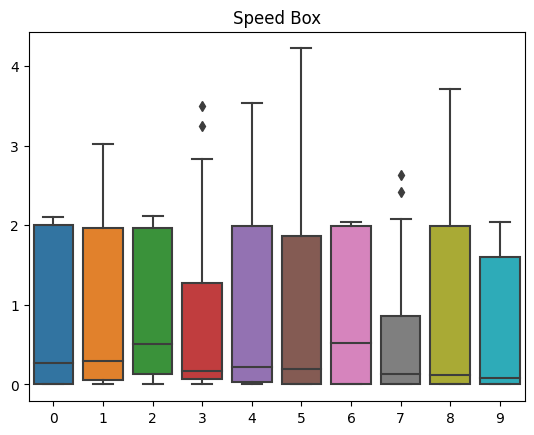

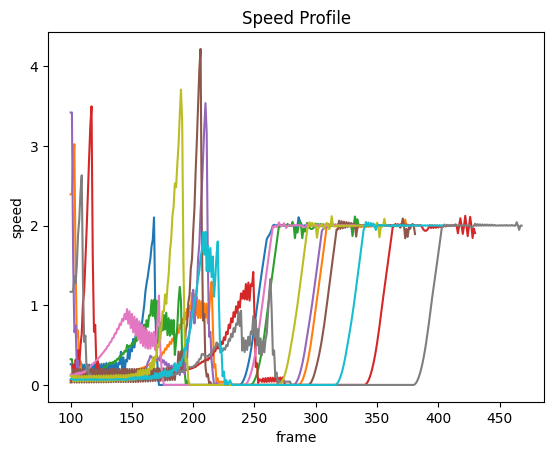

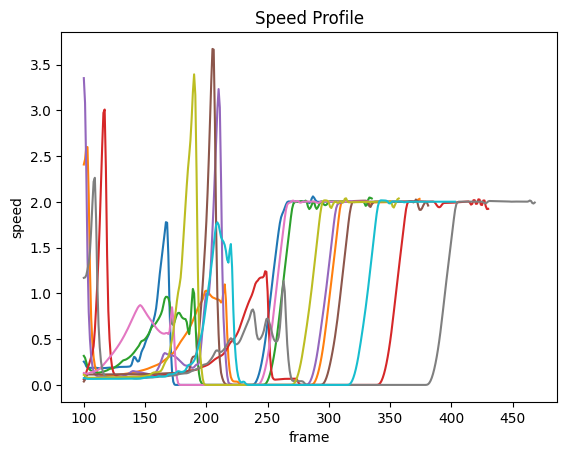

In [14]:
speedSeres = []
pedIds = pedDf["uniqueTrackId"].unique()
pedIds = pedIds[:limit]
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    speedSeres.append(aPed["speed"])
    # print("avg speed", aPed["speed"].mean())
    # print("max speed", aPed["speed"].max())
sns.boxplot(speedSeres)
plt.title("Speed Box")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

x = range(500)
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speed", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Speed Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Speed Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

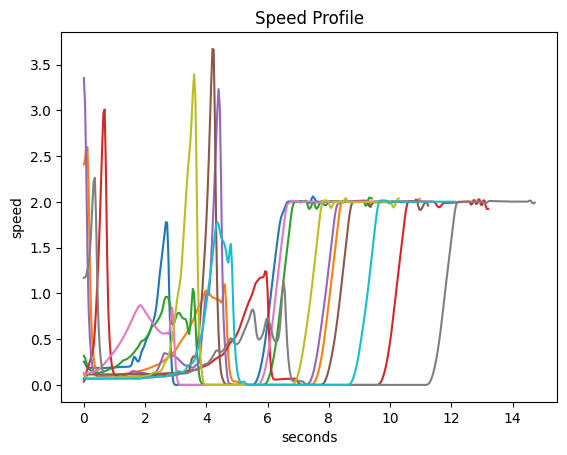

In [15]:
# visualization in seconds
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    # aPed = aPed.iloc[::int(fps//25), :] # frame rate is 25
    # seconds = (list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps)
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("seconds")
plt.ylabel("speed")
plt.title("Speed Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()


# Frozen State Stats and Visualization

In [16]:
frozenPedDf = pedDf[pedDf['state'] == 'FROZEN'].copy()
pedIds = frozenPedDf["uniqueTrackId"].unique()

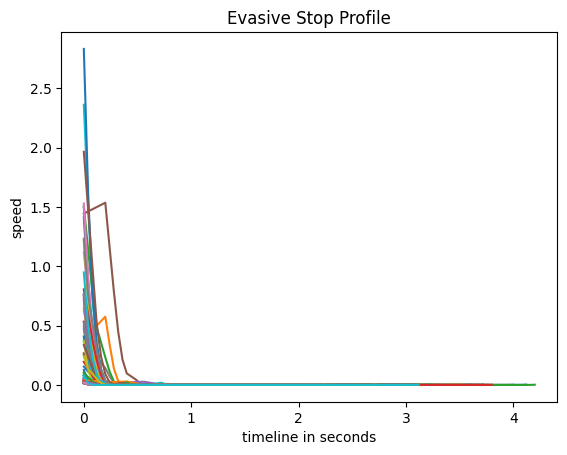

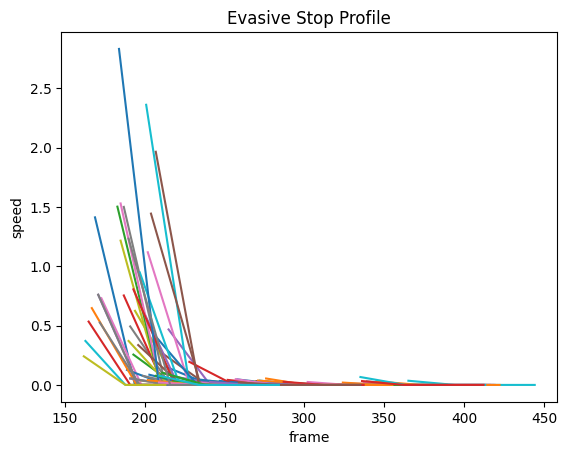

In [17]:
# visualization in seconds
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline in seconds")
plt.ylabel("speed")
plt.title("Evasive Stop Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()
# visualization in frames
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    aPed = aPed.iloc[::int(fps), :] # frame rate is 25
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Evasive Stop Profile")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

# Statistics

In [18]:
from collections import defaultdict

In [19]:
# Pedestrian statistics
pedIds = pedDf["uniqueTrackId"].unique()
colData = defaultdict(lambda: list())
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    colData['uniqueTrackId'].append(pedId)
    colData['speed-avg'].append(aPed['speed'].mean())
    colData['speed-max'].append(aPed['speed'].max())
    colData['speed-min'].append(aPed['speed'].min())
    
    aPedFrozen = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    colData['stop-duration'].append(len(aPedFrozen) / fps)

pedStats = pd.DataFrame(colData)
pedStats.head()

,uniqueTrackId,speed-avg,speed-max,speed-min,stop-duration
0,1000447,0.814910,2.105765,0.0,2.80
1,2000450,0.758498,3.023658,0.0,2.40
2,3000453,0.817739,2.114786,0.0,2.16
3,4000456,0.669920,3.499209,0.0,2.64
4,5000459,0.752669,3.539347,0.0,2.68


In [30]:
# Vehicle statistics
vIds = otherDf["uniqueTrackId"].unique()
colData = defaultdict(lambda: list())
for vId in vIds:
    aV = otherDf[otherDf["uniqueTrackId"] == vId]
    colData['uniqueTrackId'].append(vId)
    colData['speed-avg'].append(aV['speed'].mean())
    colData['speed-max'].append(aV['speed'].max())
    colData['speed-min'].append(aV['speed'].min())
    
vehicleStats = pd.DataFrame(colData)
vehicleStats.tail()

,uniqueTrackId,speed-avg,speed-max,speed-min
95,96000731,12.188654,16.128985,6.606317
96,97000734,15.811097,16.393004,11.134986
97,98000737,17.041592,20.724596,6.560161
98,99000740,17.908399,22.976333,8.055814
99,100000743,14.216859,16.041947,9.952376


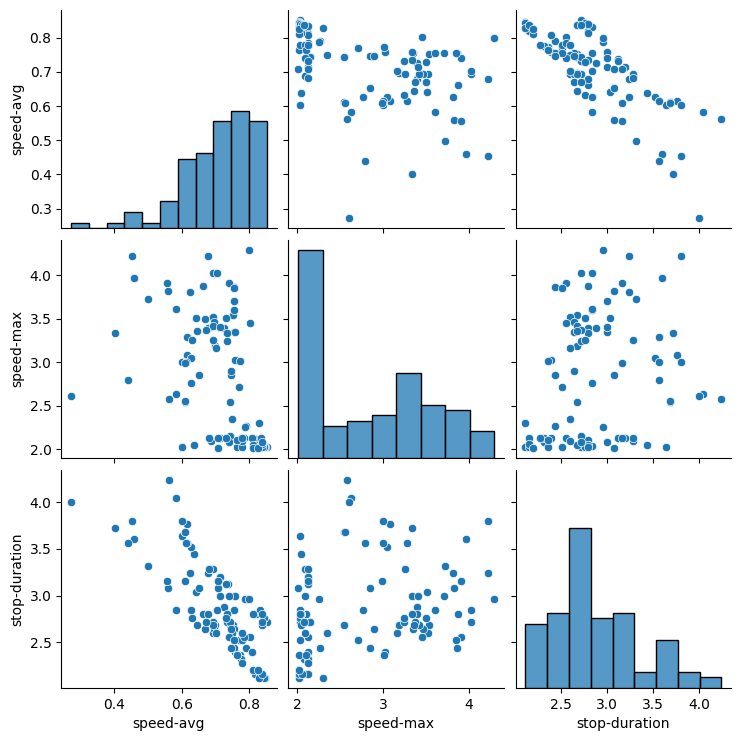

In [21]:
# Stop duration

sns.pairplot(pedStats[['speed-avg', 'speed-max', 'stop-duration']])

plt.xlabel("Correlations")
# plt.ylabel("speed")
# plt.title("Stop Duration")
plt.show()

# Marginal Distributions

In [ ]:
plt.rcParams.update({'font.size': 22})

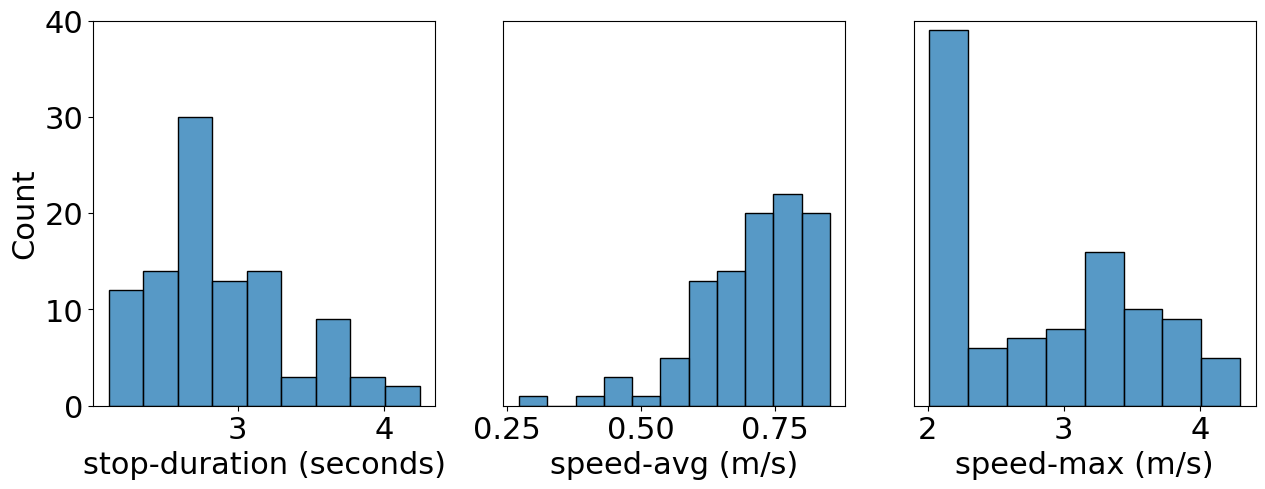

In [50]:
# Pedestrian Marginal Distributions
fig, axes = plt.subplots(1,3, figsize = (15,5))
sns.histplot(pedStats['stop-duration'] ,ax=axes[0])
axes[0].set_xlabel("stop-duration (seconds)")
axes[0].set_ylim(0, 40)

sns.histplot(pedStats['speed-avg'] ,ax=axes[1])
axes[1].set_xlabel("speed-avg (m/s)")
axes[1].set_ylim(0, 40)
axes[1].get_yaxis().set_visible(False)


sns.histplot(pedStats['speed-max'] ,ax=axes[2])
axes[2].set_xlabel("speed-max (m/s)")
axes[2].set_ylim(0, 40)
axes[2].get_yaxis().set_visible(False)

plt.show()

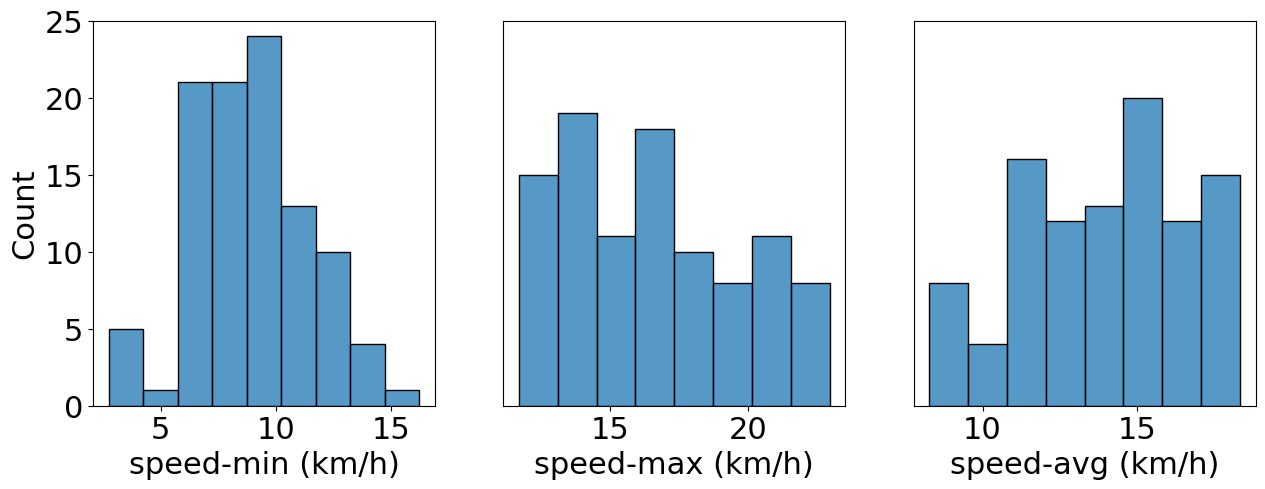

In [53]:
# Vehicle Marginal Distributions
fig, axes = plt.subplots(1, 3, figsize = (15,5))

sns.histplot(vehicleStats['speed-min'] ,ax=axes[0], label="km/h")
axes[0].set_xlabel("speed-min (km/h)")
axes[0].set_ylim(0, 25)

sns.histplot(vehicleStats['speed-max'] ,ax=axes[1])
axes[1].set_xlabel("speed-max (km/h)")
axes[1].set_ylim(0, 25)
axes[1].get_yaxis().set_visible(False)

sns.histplot(vehicleStats['speed-avg'] ,ax=axes[2])
axes[2].set_xlabel("speed-avg (km/h)")
axes[2].set_ylim(0, 25)
axes[2].get_yaxis().set_visible(False)

plt.show()

# Self joint probabilities

In [88]:
def plotJoint(data, x, y, height=10, bar='left', xTitle=None, yTitle=None):
    g = sns.JointGrid(data=pedStats, x=x, y=y, height=height)
    
    # g.plot(sns.scatterplot, sns.histplot)
    
    if bar == 'right':
        cax = g.figure.add_axes([1.0, .1, .02, .75])
    else:
        cax = g.figure.add_axes([.15, .15, .02, .2])
    # Add the joint and marginal histogram plots
    j = g.plot_joint(
        sns.histplot, discrete=(False, False),
        pmax=.8, cbar=True, cbar_ax=cax
    )
    if xTitle is None:
        xTitle = x
    if yTitle is None:
        yTitle = y
    j.set_axis_labels(xTitle, yTitle)
    g.plot_marginals(sns.histplot, element="step")
    

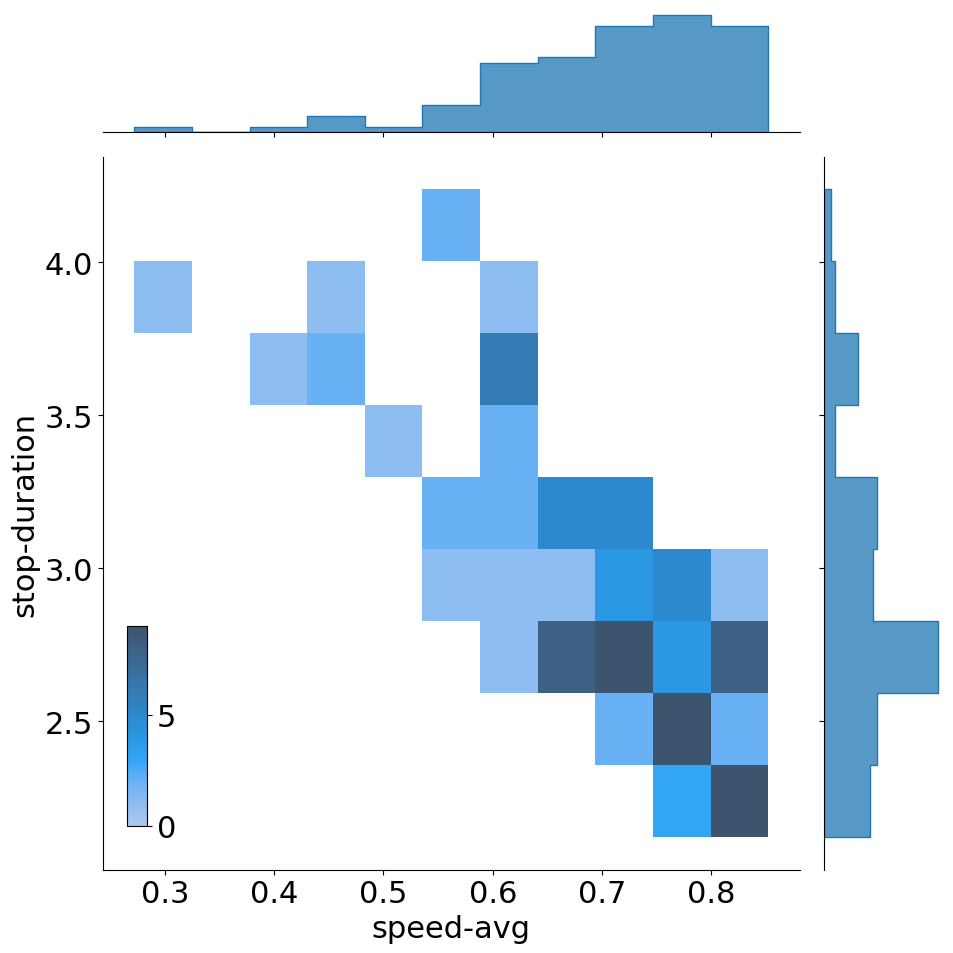

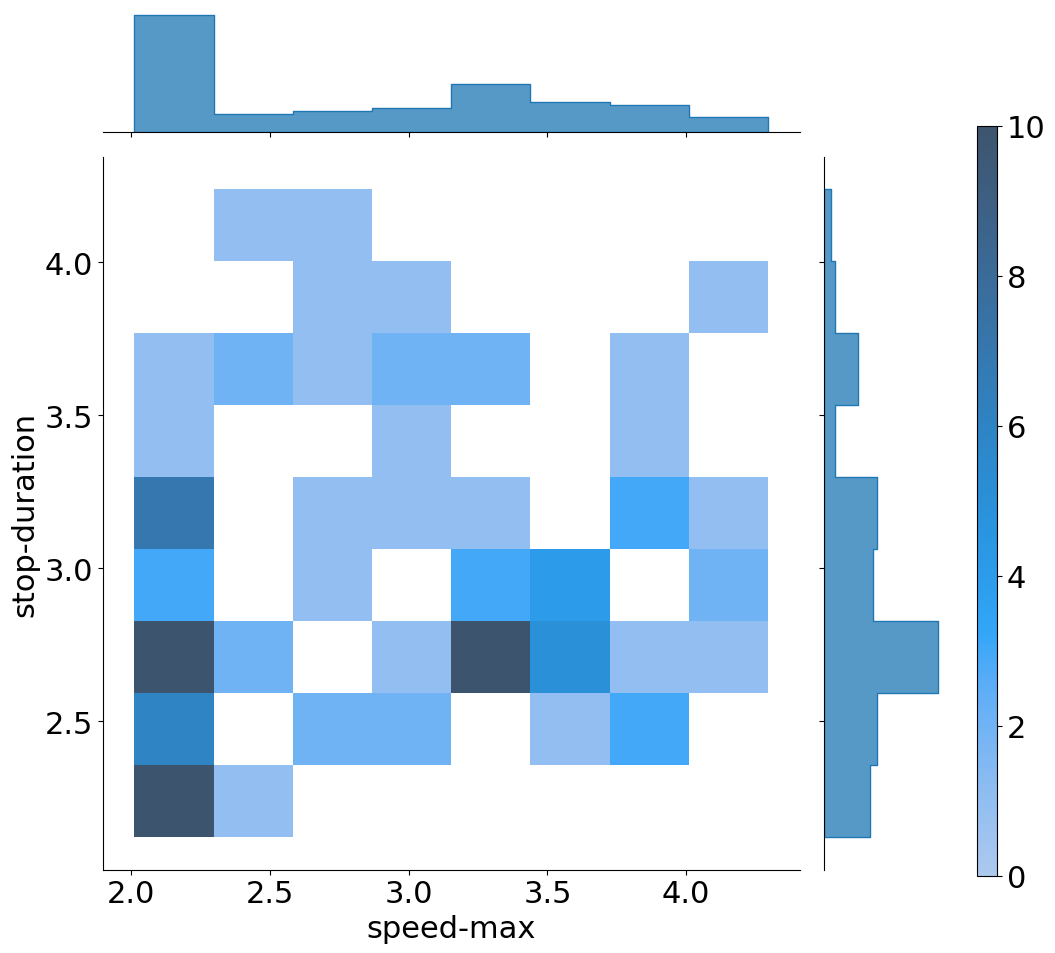

In [89]:

# g = sns.JointGrid(data=pedStats, x="speed-avg", y="stop-duration", height=10)
# # g.plot(sns.scatterplot, sns.histplot)

# cax = g.figure.add_axes([.15, .15, .02, .2])
# # Add the joint and marginal histogram plots
# j = g.plot_joint(
#     sns.histplot, discrete=(False, False),
#     cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
# )
# g.plot_marginals(sns.histplot, element="step", color="#03012d")

plotJoint(data=pedStats, x="speed-avg", y="stop-duration", height=10)
plotJoint(data=pedStats, x="speed-max", y="stop-duration", height=10, bar='right')


In [54]:
# g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="hist", height=10)
# ax = g.ax_joint
# cbar_ax = kdeplot.fig.add_axes([.85, .25, .05, .4])
# # plt.colorbar(ax=ax, cax=cbar_ax)
# # plt.show()
# PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
# print(PCM)
# plt.colorbar(PCM, ax=ax, cax=cbar_ax) 


In [26]:
# g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="kde", height=10)

In [27]:
# g = sns.jointplot(x=pedStats['speed-max'], y=pedStats['stop-duration'], kind="kde", height=10)

# Vehicle joint plots

In [81]:
# 1. create ped vehicle map

# mapping
pedToVehicle = getPedToVIds(meta)
# print(pedToVehicle)

# combine stats
# each ped row has a combination with each associated vehicle
pedCols = ['uniqueTrackId', 'stop-duration', 'speed-avg']
vehCols = ['uniqueTrackId', 'speed-avg']

newCols = ['pId', 'p-stop-duration', 'p-speed-avg', 'vId', 'v-speed-avg']

pedIds = pedStats['uniqueTrackId'].unique()
vIds = vehicleStats['uniqueTrackId'].unique()
jointRows = []
for pedId in pedIds:
    aPed = pedStats[pedStats["uniqueTrackId"] == pedId]
    aPed = aPed[pedCols]
    vIds = pedToVehicle[pedId]
    for vId in vIds:
        aV = vehicleStats[vehicleStats["uniqueTrackId"] == vId]
        aV = aV[vehCols]
        jointRows.append(pd.concat([aPed, aV], axis=1, ignore_index=True))

jointStats = pd.concat(jointRows, ignore_index=True)
jointStats.columns = newCols

assert len(pedStats) == len(jointStats)

jointStats.head()
# jointStats[0]

,pId,p-stop-duration,p-speed-avg,vId,v-speed-avg
0,1000447,2.80,0.814910,1000446,17.096213
1,2000450,2.40,0.758498,2000449,14.457353
2,3000453,2.16,0.817739,3000452,17.084038
3,4000456,2.64,0.669920,4000455,11.866340
4,5000459,2.68,0.752669,5000458,15.309688


ValueError: Could not interpret value `v-speed-avg` for parameter `x`

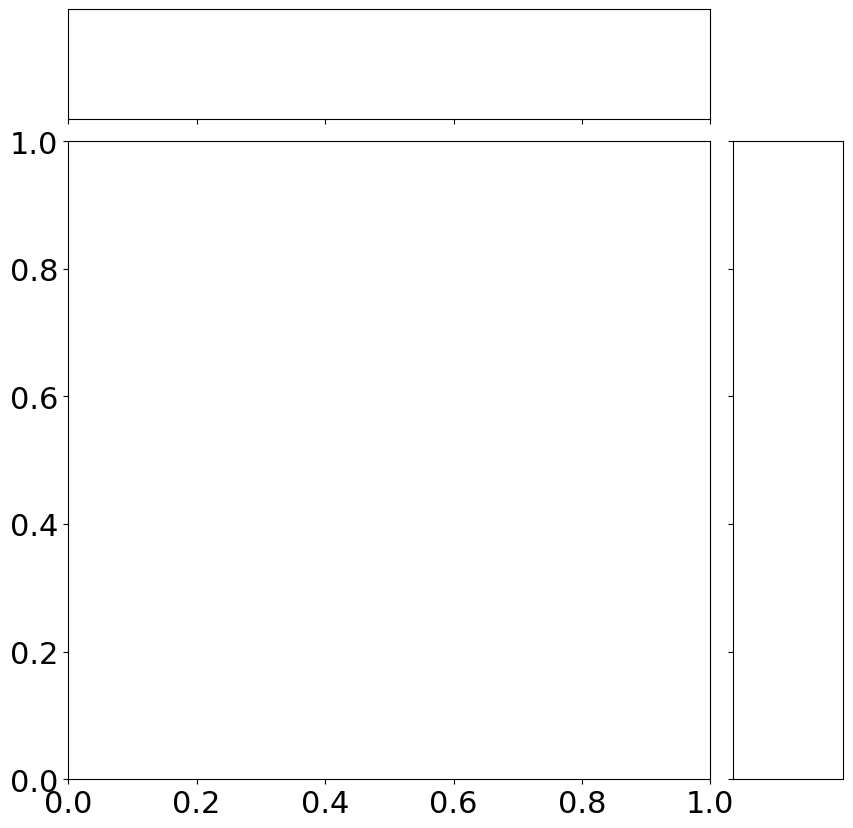

In [90]:
# 2. vehicle speed vs ped speed
plotJoint(data=jointStats, x="v-speed-avg", y="p-speed-avg", height=10, xTitle="vehicle speed (km/h)", yTitle="pedestrian speed (m/s)")
# 3. vehicle speed vs ped stop duration
# 4. vehicle speed vs ped stop location